# Paper Information
## FurryGAN: High Quality Foreground-aware Image Synthesis

- Paper Link: https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136740679.pdf
- Authors: Jeongmin Bae, Mingi Kwon, and Youngjung Uh
- Conference: ECCV 2022

## Project Group Members
- Batuhan Bal, bal.batuhan@metu.edu.tr
- Onat Özdemir, onat.ozdemir@metu.edu.tr


# Import Libraries

In [2]:
%matplotlib inline
import argparse
import os

import torch
import torch.optim as optim

from models import Generator, Discriminator, MaskGenerator
from dataset import load_data
from train import train
from utils import set_fix_seed, save_model, load_model, generate_results, show_image_grid, print_metrics, save_generated_images, load_tracer_masks

import warnings
warnings.filterwarnings("ignore")

set_fix_seed(0)

# Hyperparameters

In [3]:
parser = argparse.ArgumentParser(description='FurryGAN')
args = parser.parse_args(args=[])
args.data_path = "./data"
args.model_save_path = "./models"
args.image_size = 256
args.num_channels = 32
args.max_channels = 128
args.batch_size = 16
args.latent_size = 128
args.style_dim = 128
args.num_iters = 1000
args.lr = 0.002
args.reg_every = 16

args.gamma_start = 0.0
args.gamma_max = 1.0
args.gamma_step = 0.01
args.phi1 = 0.35
args.phi2 = 0.01
args.lambda_coarse = 5.0
args.lambda_fine = 5.0
args.lambda_min = 0.5
args.truncation = 0.7
args.mask_threshold = 0.5
args.r1 = 10.0

args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train and Save the Model

Iteration: 100, Generator Loss: 2.4700, Discriminator Loss: 1.7467
Iteration: 200, Generator Loss: 2.2802, Discriminator Loss: 1.8484
Iteration: 300, Generator Loss: 2.2216, Discriminator Loss: 1.9431
Iteration: 400, Generator Loss: 1.8595, Discriminator Loss: 2.0451
Iteration: 500, Generator Loss: 1.3030, Discriminator Loss: 2.1288
Iteration: 600, Generator Loss: 1.2055, Discriminator Loss: 2.3443
Iteration: 700, Generator Loss: 1.1610, Discriminator Loss: 2.1494
Iteration: 800, Generator Loss: 1.0840, Discriminator Loss: 2.1735
Iteration: 900, Generator Loss: 1.0652, Discriminator Loss: 2.1229
Iteration: 1000, Generator Loss: 1.0904, Discriminator Loss: 2.2031


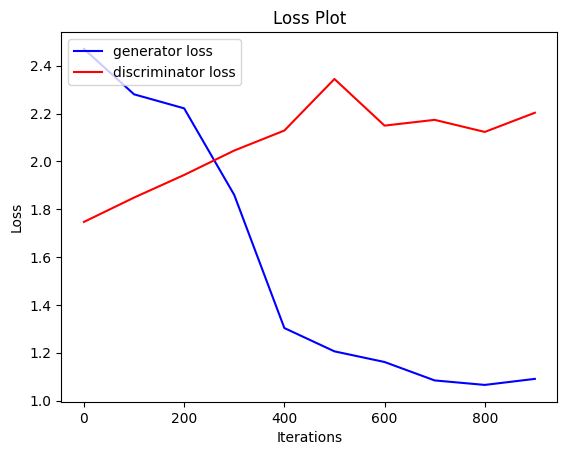

In [6]:
# Load the data
train_loader, test_loader = load_data(args)

# Initialize the models
fg_generator = Generator(args=args, mode="foreground").to(args.device)
bg_generator = Generator(args=args, mode="background").to(args.device)
mask_generator = MaskGenerator(args=args).to(args.device)
discriminator = Discriminator(args=args).to(args.device)

# Initialize the optimizers
regulation_ratio = args.reg_every / (args.reg_every + 1)
generator_params = (
    list(fg_generator.parameters())
    + list(bg_generator.parameters())
    + list(mask_generator.parameters())
)
generator_optim = optim.Adam(
    generator_params,
    lr=args.lr,
    betas=(0.0, 0.99),
)
discriminator_optim = optim.Adam(
    discriminator.parameters(),
    lr=args.lr * regulation_ratio,
    betas=(0.0, 0.99**regulation_ratio),
)

# Train the models
models = [fg_generator, mask_generator, bg_generator]
save_paths = [
    os.path.join(args.model_save_path, "fg_generator.pt"),
    os.path.join(args.model_save_path, "mask_generator.pt"),
    os.path.join(args.model_save_path, "bg_generator.pt"),
]
train(
    fg_generator,
    mask_generator,
    bg_generator,
    discriminator,
    generator_optim,
    discriminator_optim,
    train_loader,
    args,
)

# Save the models
save_model(args, models, save_paths)

# Load the Pretrained Model and Compute the Qualitative Results

The qualitative results displayed in this section aim to generate the Fig. 9 (b).

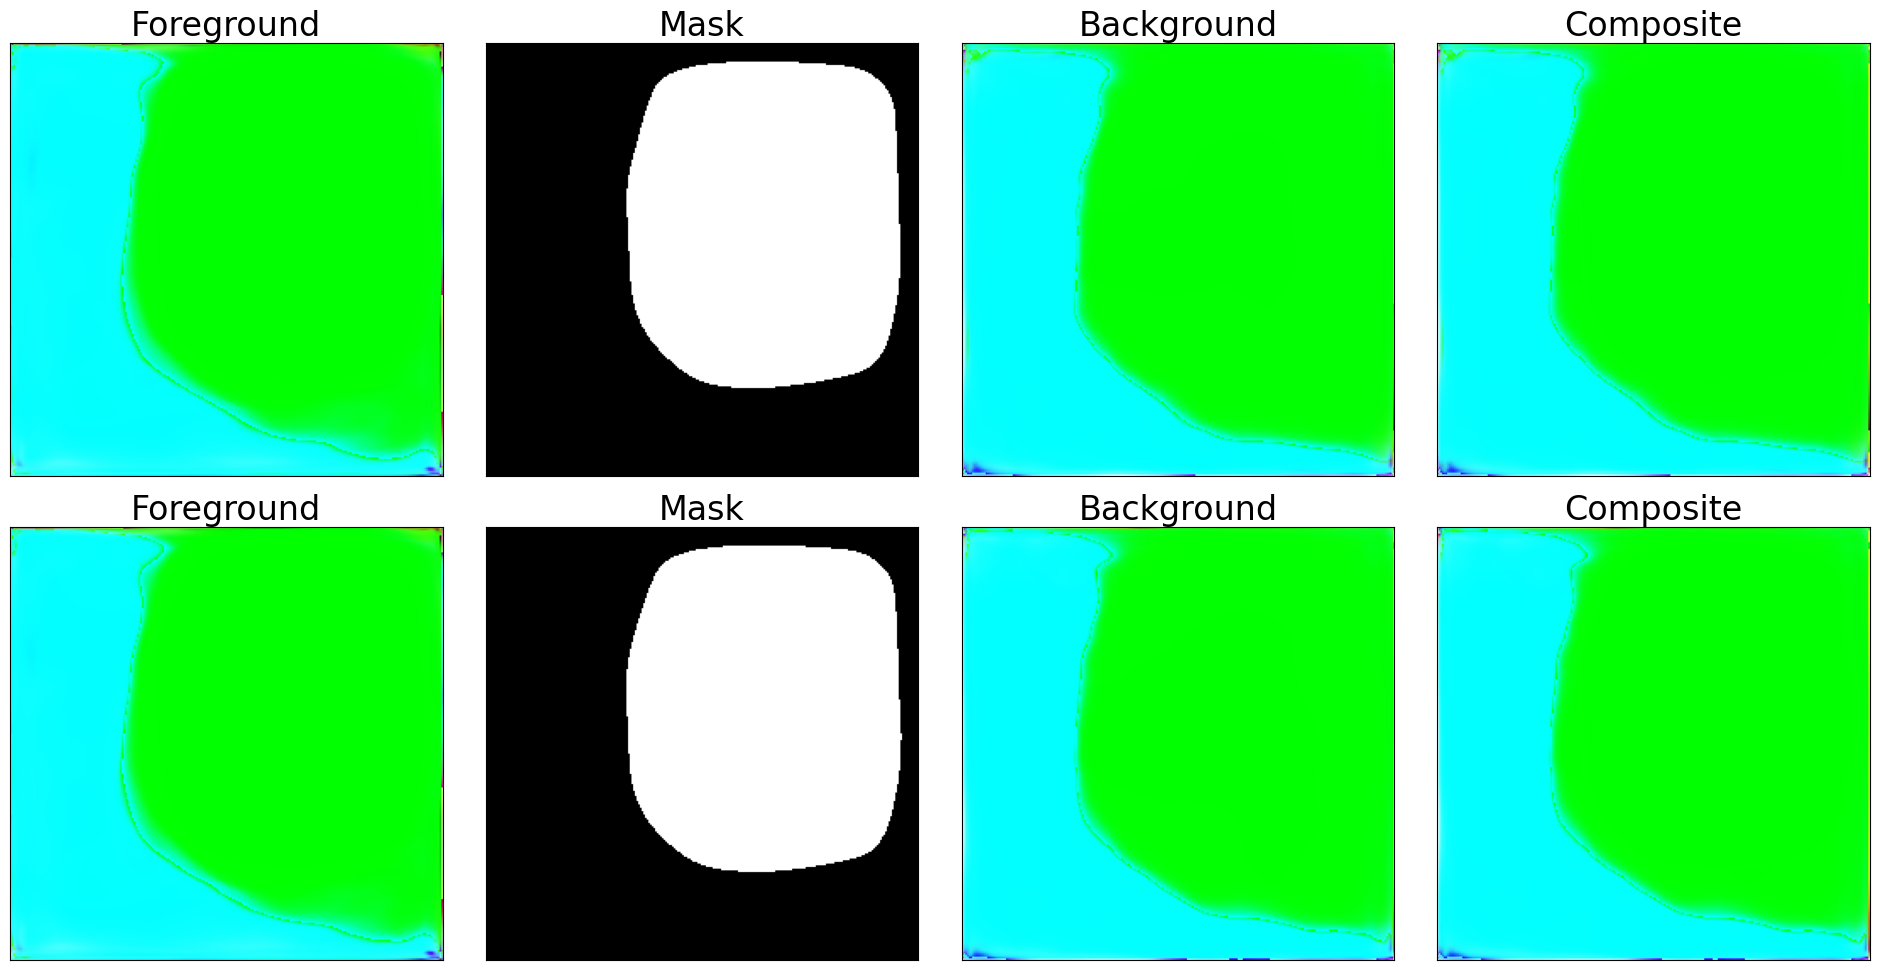

In [7]:
# Initialize the models
fg_generator = Generator(args=args, mode="foreground").to(args.device)
bg_generator = Generator(args=args, mode="background").to(args.device)
mask_generator = MaskGenerator(args=args).to(args.device)
discriminator = Discriminator(args=args).to(args.device)

# Load the models
load_paths = [
    os.path.join(args.model_save_path, "fg_generator.pt"),
    os.path.join(args.model_save_path, "mask_generator.pt"),
    os.path.join(args.model_save_path, "bg_generator.pt"),
]
models = [fg_generator, mask_generator, bg_generator]
load_model(models, load_paths)

# Generate the results
fg_images, masks, bg_images, comp_images = generate_results(
    args, fg_generator, mask_generator, bg_generator, sample_size=2
)

# Show the results
show_image_grid(fg_images, masks, bg_images, comp_images)


# Compute the Quantitative Results

The quantitative results displayed in this section aim to generate Table 2 and Table 3 given in the original paper.

In [8]:
fg_images, masks, bg_images, comp_images = generate_results(
    args, fg_generator, mask_generator, bg_generator, sample_size=args.batch_size
)
save_generated_images(comp_images)

In [9]:
!python ./TRACER/main.py

<----- Initializing inference mode ----->
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b7-4652b6dd.pth
100% 255M/255M [00:04<00:00, 56.9MB/s]
Loaded pretrained weights for efficientnet-b7
Downloading: "https://github.com/Karel911/TRACER/releases/download/v1.0/TRACER-Efficient-7.pth" to /root/.cache/torch/hub/checkpoints/TRACER-Efficient-7.pth
100% 255M/255M [00:03<00:00, 70.0MB/s]
###### pre-trained Model restored #####
test length : 16
100% 4/4 [00:03<00:00,  1.03it/s]
time: 3.896s


In [10]:
gt_fg_masks = load_tracer_masks(args.batch_size)
gt_bg_masks = 1 - gt_fg_masks

real_images = next(iter(test_loader))[0].to(args.device)
fg_masks = masks
bg_masks = 1 - masks
print_metrics(
    real_images, comp_images, gt_fg_masks, fg_masks, gt_bg_masks, bg_masks, args.device
)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 38.9MB/s]


+--------------------+--------+--------+------+--------+-----------+------+----------+
|      Dataset       | fg IoU | bg IoU | mIoU | recall | precision |  F1  | Accuracy |
+--------------------+--------+--------+------+--------+-----------+------+----------+
| AFHQv2-Cat (Ours)  |  0.02  |  0.58  | 0.3  |  24.8  |    0.31   | 0.62 |   0.55   |
| AFHQv2-Cat (Paper) |  0.95  |  0.87  | 0.91 |  0.98  |    0.97   | 0.97 |   0.95   |
+--------------------+--------+--------+------+--------+-----------+------+----------+
+--------------------+--------+
|      Dataset       |  FID   |
+--------------------+--------+
| AFHQv2-Cat (Ours)  | 420.69 |
| AFHQv2-Cat (Paper) |  6.34  |
+--------------------+--------+


# Difficulties Encountered

- The paper does not provide some details about the changes that are made to the original StyleGAN2 architecture. For example, they  mentioned that they used shallower version of the mapping network, but they did not provide the details of the architecture of the mapping networks. So, we had to make following assumptions:
    - The mapping networks have 4 layers instead of 8 layers.
    - The number of channels in the mapping networks is 128 instead of 512.
- The paper does not provide some details of the discriminator architecture. For example, dimension of input style vector is not mentioned. So, we assumed that the dimension of the input style vector is 128.
- The paper does not mention path length regularization. So, we did not use it.
- In the paper, the authors had calculated IoU for the foreground and background masks separately. However, we could not understand the meaning of background mask. So, we calculated background mask as (1 - foreground) mask.